In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import tqdm as notebook_tqdm
from sklearn.cluster import DBSCAN
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

c:\Users\romin\Desktop\Projects\project-nlp-log-classification-main\nlp_c\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [50]:

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# If your resampled labels are in y_res (after SMOTE or undersampling)
def plot_class_distribution(y, title='Class Distribution'):
    class_counts = pd.Series(y).value_counts().sort_values(ascending=False)
    plt.figure(figsize=(8, 5))
    sns.barplot(x=class_counts.values, y=class_counts.index, palette="Blues_d")
    plt.title(title, fontsize=14)
    plt.xlabel('Count')
    plt.ylabel('Class')
    for index, value in enumerate(class_counts.values):
        plt.text(value + 1, index, str(value), va='center')
    plt.tight_layout()
    plt.show()


In [39]:
import pandas as pd
df = pd.read_csv("dataset/new_synthetic_logs.csv")
# df = pd.read_csv("dataset/synthetic_logs.csv") # Load the old dataset
df.head()

,timestamp,log_message,target_label
0,6/27/2025 7:20,nova.osapi_compute.wsgi.server [req-b9718cd8-f...,HTTP Status
1,1/14/2025 23:07,Email service experiencing issues with sending,Critical Error
2,1/17/2025 1:29,Unauthorized access to data was attempted,Security Alert
3,7/12/2025 0:24,nova.osapi_compute.wsgi.server [req-4895c258-b...,HTTP Status
4,6/2/2025 18:25,nova.osapi_compute.wsgi.server [req-ee8bc8ba-9...,HTTP Status


In [24]:
print('df imbalanced shape:', df.shape)
df = df[df['target_label'] != 'HTTP Status']
print('df balanced shape:', df.shape)

df imbalanced shape: (2259, 3)
df balanced shape: (1242, 3)


In [40]:
df.target_label.unique()

array(['HTTP Status', 'Critical Error', 'Security Alert', 'Error',
       'System Notification', 'Resource Usage'], dtype=object)

Applications of sentence_transformers:

The generated sentence embeddings can be used for a wide range of tasks, including:

    1. Semantic Textual Similarity: Comparing sentences for their semantic similarity.

    2. Semantic Search: Finding relevant documents or passages based on semantic meaning.

    3. Clustering: Grouping similar sentences or documents.
    
    4. Paraphrase Mining: Identifying paraphrased sentences.

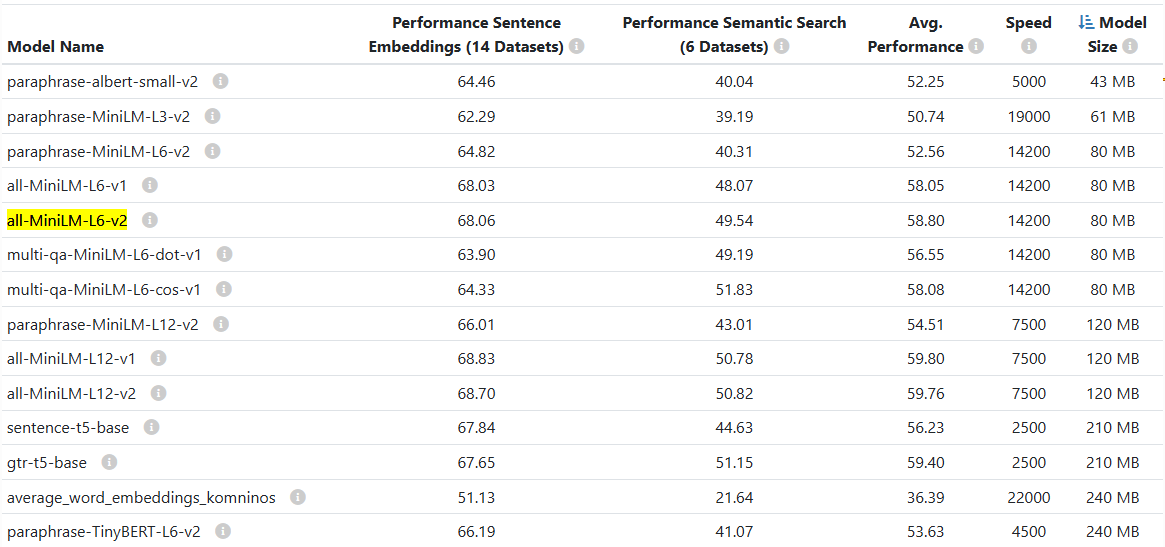

In [41]:
model = SentenceTransformer('all-MiniLM-L6-v2')  # Lightweight embedding model

# model = SentenceTransformer('paraphrase-MiniLM-L3-v2')
embeddings = model.encode(df['log_message'].tolist())

In [42]:
clustering = DBSCAN(eps=0.2, min_samples=1, metric='cosine').fit(embeddings)
df['cluster'] = clustering.labels_

In [43]:
df.head()

,timestamp,log_message,target_label,cluster
0,6/27/2025 7:20,nova.osapi_compute.wsgi.server [req-b9718cd8-f...,HTTP Status,0
1,1/14/2025 23:07,Email service experiencing issues with sending,Critical Error,1
2,1/17/2025 1:29,Unauthorized access to data was attempted,Security Alert,2
3,7/12/2025 0:24,nova.osapi_compute.wsgi.server [req-4895c258-b...,HTTP Status,0
4,6/2/2025 18:25,nova.osapi_compute.wsgi.server [req-ee8bc8ba-9...,HTTP Status,0


In [44]:
# Group by cluster to inspect patterns
clusters = df.groupby('cluster')['log_message'].apply(list)
sorted_clusters = clusters.sort_values(key=lambda x: x.map(len), ascending=False)

In [45]:
print("Clustered Patterns:")
for cluster_id, messages in sorted_clusters.items():
    if len(messages) > 10:
        print(f"Cluster {cluster_id}:")
        for msg in messages[:5]:
            print(f"  {msg}")

Clustered Patterns:
Cluster 0:
  nova.osapi_compute.wsgi.server [req-b9718cd8-f65e-49cc-8349-6cf7122af137 113d3a99c3da401fbd62cc2caa5b96d2 54fadb412c4e40cdbaed9335e4c35a9e - - -] 10.11.10.1 "GET /v2/54fadb412c4e40cdbaed9335e4c35a9e/servers/detail HTTP/1.1" status: 200 len: 1893 time: 0.2675118
  nova.osapi_compute.wsgi.server [req-4895c258-b2f8-488f-a2a3-4fae63982e48 113d3a99c3da401fbd62cc2caa5b96d2 54fadb412c4e40cdbaed9335e4c35a9e - - -] 10.11.10.1 "GET /v2/54fadb412c4e40cdbaed9335e4c35a9e/servers/detail HTTP/1.1" HTTP status code -  200 len: 211 time: 0.0968180
  nova.osapi_compute.wsgi.server [req-ee8bc8ba-9265-4280-9215-dbe000a41209 113d3a99c3da401fbd62cc2caa5b96d2 54fadb412c4e40cdbaed9335e4c35a9e - - -] 10.11.10.1 "GET /v2/54fadb412c4e40cdbaed9335e4c35a9e/servers/detail HTTP/1.1" RCODE  200 len: 1874 time: 0.2280791
  nova.osapi_compute.wsgi.server [req-f0bffbc3-5ab0-4916-91c1-0a61dd7d4ec2 113d3a99c3da401fbd62cc2caa5b96d2 54fadb412c4e40cdbaed9335e4c35a9e - - -] 10.11.10.1 "GET /v2

In [46]:
df.cluster.unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126])

x: 2259, y: 2259


C:\Users\romin\AppData\Local\Temp\ipykernel_1068\3764437809.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.values, y=class_counts.index, palette="Blues_d")


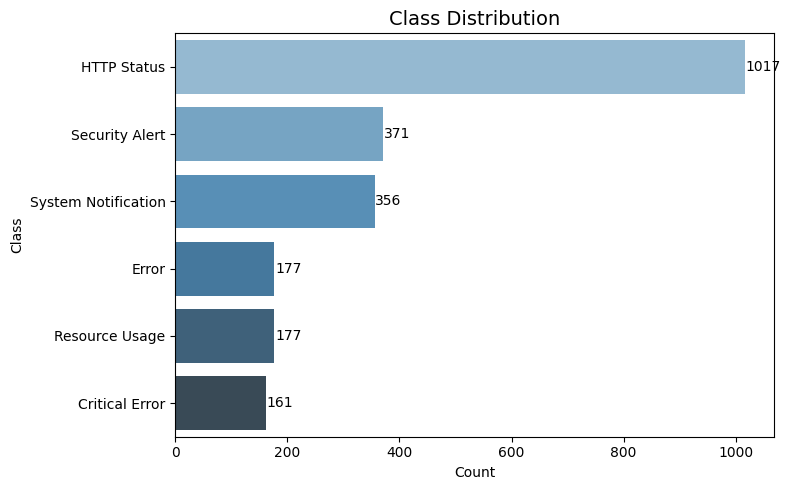

In [87]:
# Prepare data for training
X = embeddings
y = df['target_label'].values
print(f'x: {len(X)}, y: {len(y)}')
plot_class_distribution(y)

C:\Users\romin\AppData\Local\Temp\ipykernel_1068\3764437809.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.values, y=class_counts.index, palette="Blues_d")


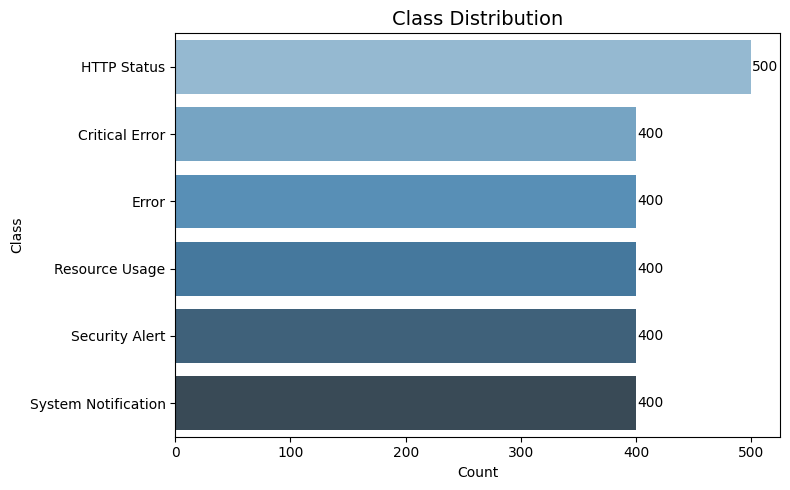

In [88]:
# balancing data 
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

undersample = RandomUnderSampler(
    sampling_strategy={'HTTP Status': 500}, random_state=42
)
X_under, y_under = undersample.fit_resample(X, y)
# For example: sample all minority classes to 400 (less than 1017)
smote = SMOTE(sampling_strategy={
    'Critical Error': 400,
    'Resource Usage': 400,
    'Error': 400,
    'System Notification': 400,
    'Security Alert': 400
}, random_state=42)

X, y = smote.fit_resample(X_under, y_under)
plot_class_distribution(y)

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

scaler = StandardScaler()  # or MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

                     precision    recall  f1-score   support

     Critical Error       1.00      1.00      1.00        80
              Error       1.00      1.00      1.00        80
        HTTP Status       1.00      1.00      1.00       100
     Resource Usage       1.00      1.00      1.00        80
     Security Alert       1.00      1.00      1.00        80
System Notification       1.00      1.00      1.00        80

           accuracy                           1.00       500
          macro avg       1.00      1.00      1.00       500
       weighted avg       1.00      1.00      1.00       500



['../models/logistic_scaler.joblib']

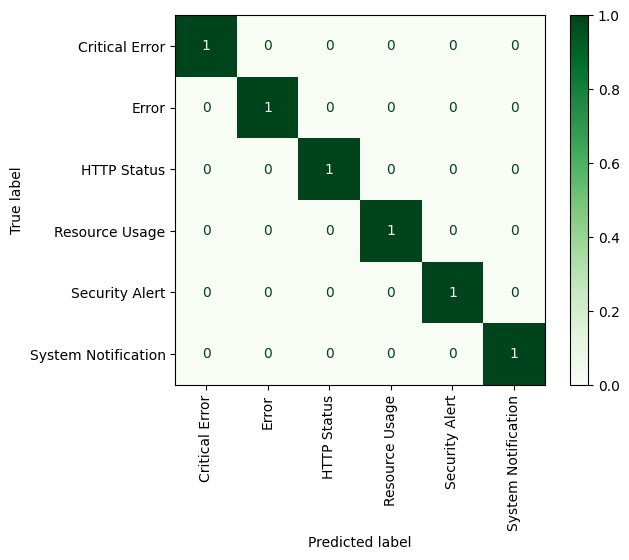

In [90]:

clf = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)


report = classification_report(y_test, y_pred)
print(report)
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap='Greens', xticks_rotation='vertical')


joblib.dump(clf, '../models/logistic.joblib')
joblib.dump(scaler, '../models/logistic_scaler.joblib')


                     precision    recall  f1-score   support

     Critical Error       1.00      0.99      0.99        80
              Error       0.99      1.00      0.99        80
        HTTP Status       1.00      1.00      1.00       100
     Resource Usage       1.00      1.00      1.00        80
     Security Alert       1.00      1.00      1.00        80
System Notification       1.00      1.00      1.00        80

           accuracy                           1.00       500
          macro avg       1.00      1.00      1.00       500
       weighted avg       1.00      1.00      1.00       500



['../models/knn.joblib']

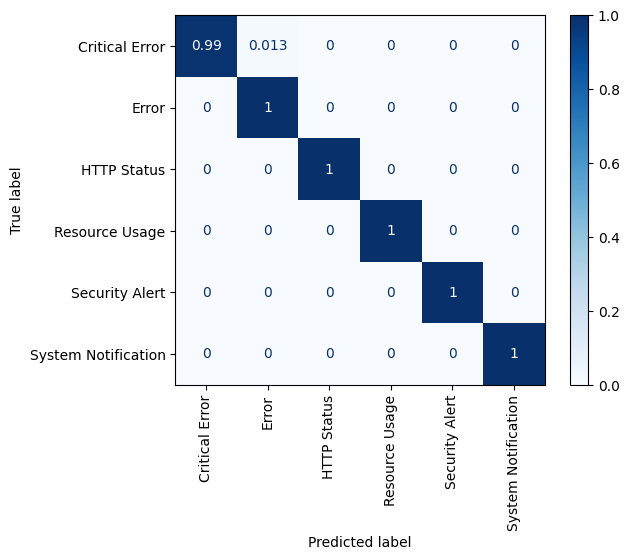

In [91]:
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap='Blues', xticks_rotation='vertical')

joblib.dump(clf, '../models/knn.joblib')

                     precision    recall  f1-score   support

     Critical Error       1.00      1.00      1.00        80
              Error       1.00      1.00      1.00        80
        HTTP Status       1.00      1.00      1.00       100
     Resource Usage       1.00      1.00      1.00        80
     Security Alert       1.00      1.00      1.00        80
System Notification       1.00      1.00      1.00        80

           accuracy                           1.00       500
          macro avg       1.00      1.00      1.00       500
       weighted avg       1.00      1.00      1.00       500



['../models/svm.joblib']

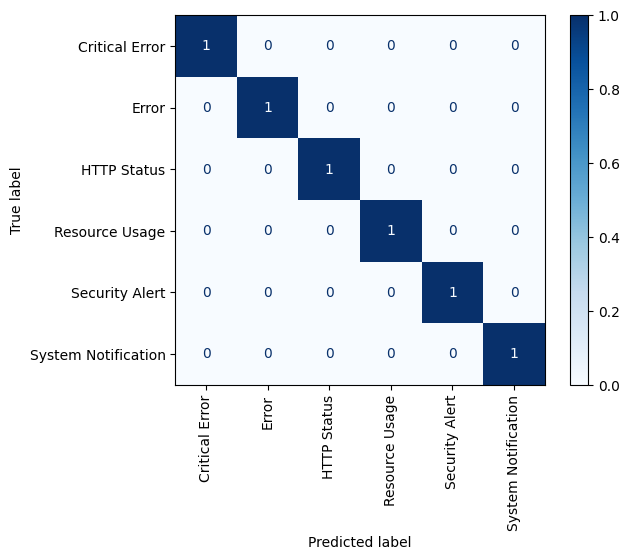

In [92]:

clf = SVC(kernel='rbf', C=1, gamma='scale', class_weight='balanced')
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap='Blues', xticks_rotation='vertical')

joblib.dump(clf, '../models/svm.joblib')

                     precision    recall  f1-score   support

     Critical Error       0.91      0.94      0.93        80
              Error       0.76      0.90      0.82        80
        HTTP Status       1.00      1.00      1.00       100
     Resource Usage       1.00      1.00      1.00        80
     Security Alert       1.00      0.79      0.88        80
System Notification       0.96      0.96      0.96        80

           accuracy                           0.93       500
          macro avg       0.94      0.93      0.93       500
       weighted avg       0.94      0.93      0.93       500



['../models/dtree.joblib']

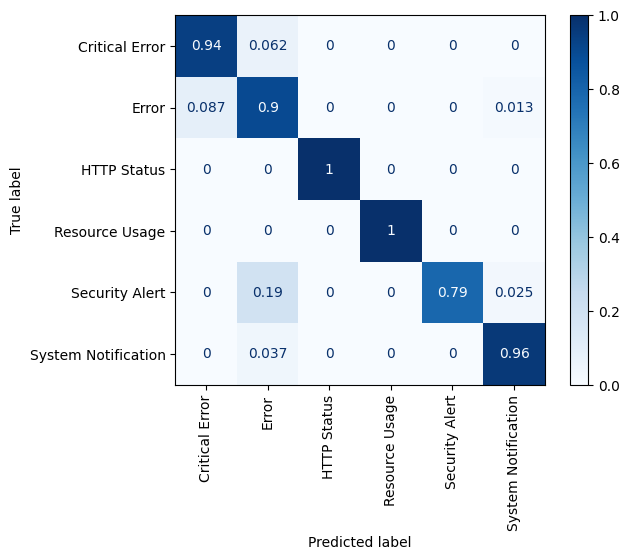

In [93]:

clf = DecisionTreeClassifier(max_depth=5, random_state=42)
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap='Blues', xticks_rotation='vertical')

joblib.dump(clf, '../models/dtree.joblib')

                     precision    recall  f1-score   support

     Critical Error       1.00      1.00      1.00        80
              Error       1.00      1.00      1.00        80
        HTTP Status       1.00      1.00      1.00       100
     Resource Usage       1.00      1.00      1.00        80
     Security Alert       1.00      1.00      1.00        80
System Notification       1.00      1.00      1.00        80

           accuracy                           1.00       500
          macro avg       1.00      1.00      1.00       500
       weighted avg       1.00      1.00      1.00       500



['../models/randomForest.joblib']

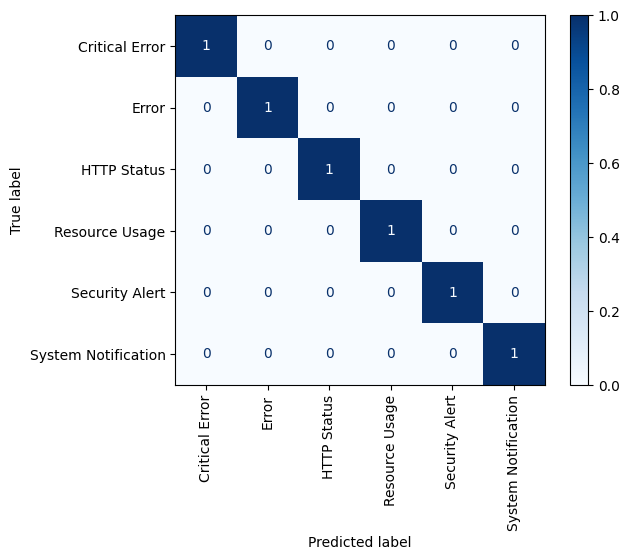

In [99]:
from imblearn.ensemble import BalancedRandomForestClassifier
clf = BalancedRandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap='Blues', xticks_rotation='vertical')

joblib.dump(clf, '../models/randomForest.joblib')

                     precision    recall  f1-score   support

     Critical Error       1.00      1.00      1.00        80
              Error       1.00      1.00      1.00        80
        HTTP Status       1.00      1.00      1.00       100
     Resource Usage       1.00      1.00      1.00        80
     Security Alert       1.00      1.00      1.00        80
System Notification       1.00      1.00      1.00        80

           accuracy                           1.00       500
          macro avg       1.00      1.00      1.00       500
       weighted avg       1.00      1.00      1.00       500



['../models/randomForest.joblib']

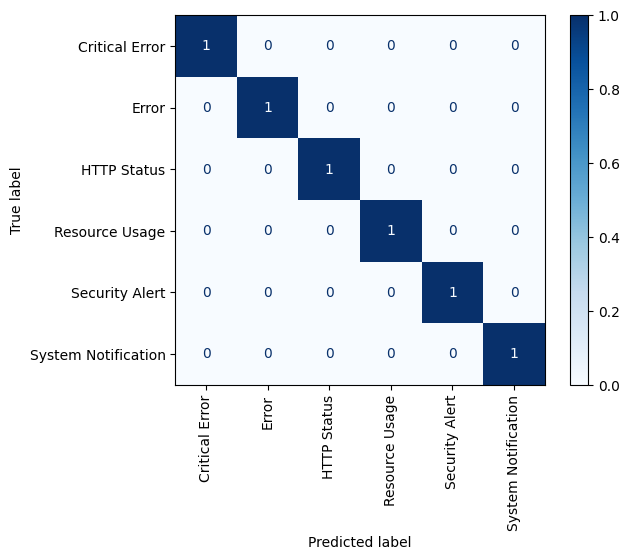

In [94]:
from sklearn.ensemble import RandomForestClassifier


clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap='Blues', xticks_rotation='vertical')

joblib.dump(clf, '../models/randomForest.joblib')

                     precision    recall  f1-score   support

     Critical Error       0.98      0.75      0.85        80
              Error       0.77      0.99      0.87        80
        HTTP Status       1.00      1.00      1.00       100
     Resource Usage       1.00      1.00      1.00        80
     Security Alert       0.99      0.95      0.97        80
System Notification       0.97      0.97      0.97        80

           accuracy                           0.95       500
          macro avg       0.95      0.94      0.94       500
       weighted avg       0.96      0.95      0.95       500



['../models/ABoost.joblib']

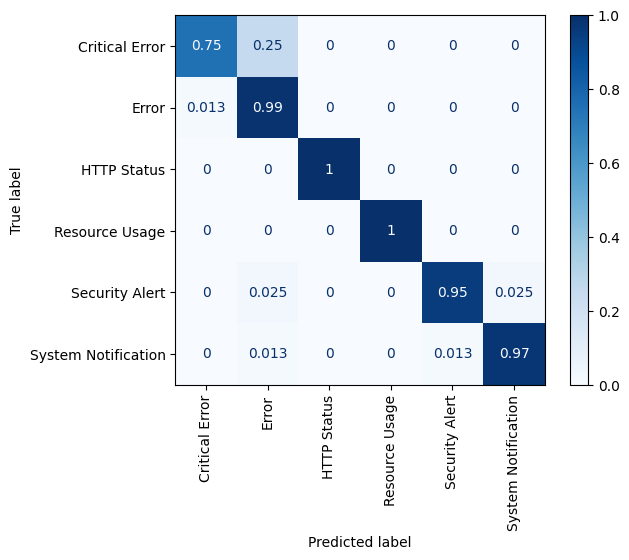

In [95]:

clf = AdaBoostClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap='Blues', xticks_rotation='vertical')

joblib.dump(clf, '../models/ABoost.joblib')

                     precision    recall  f1-score   support

     Critical Error       1.00      1.00      1.00        80
              Error       1.00      1.00      1.00        80
        HTTP Status       1.00      1.00      1.00       100
     Resource Usage       1.00      1.00      1.00        80
     Security Alert       1.00      1.00      1.00        80
System Notification       1.00      1.00      1.00        80

           accuracy                           1.00       500
          macro avg       1.00      1.00      1.00       500
       weighted avg       1.00      1.00      1.00       500



['../models/mlp.joblib']

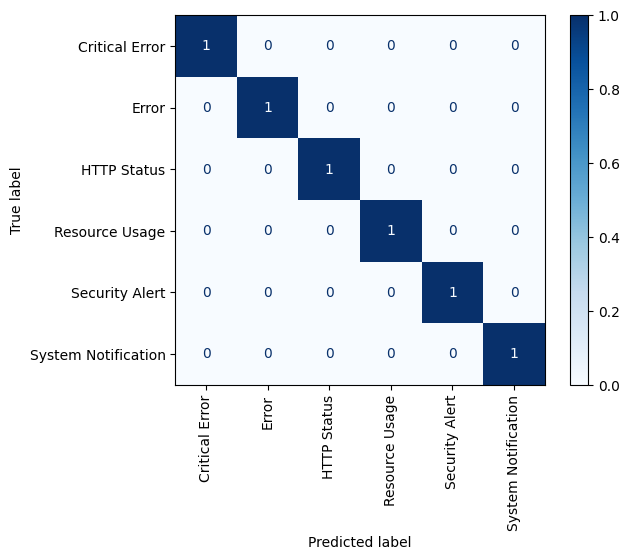

In [96]:

clf = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap='Blues', xticks_rotation='vertical')

joblib.dump(clf, '../models/mlp.joblib')

                     precision    recall  f1-score   support

     Critical Error       1.00      1.00      1.00        80
              Error       0.99      1.00      0.99        80
        HTTP Status       1.00      1.00      1.00       100
     Resource Usage       1.00      1.00      1.00        80
     Security Alert       1.00      0.99      0.99        80
System Notification       1.00      1.00      1.00        80

           accuracy                           1.00       500
          macro avg       1.00      1.00      1.00       500
       weighted avg       1.00      1.00      1.00       500



['../models/LinearDiscriminantAnalysis.joblib']

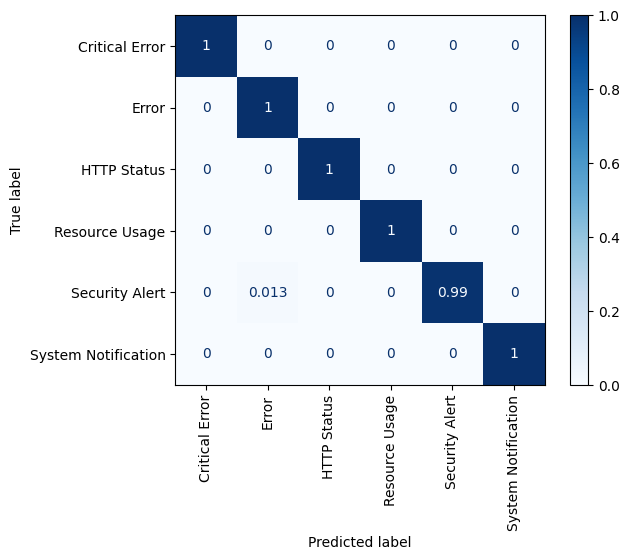

In [97]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

clf = LinearDiscriminantAnalysis()
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap='Blues', xticks_rotation='vertical')

joblib.dump(clf, '../models/LinearDiscriminantAnalysis.joblib')

c:\Users\romin\Desktop\Projects\project-nlp-log-classification-main\nlp_c\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\romin\Desktop\Projects\project-nlp-log-classification-main\nlp_c\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\romin\Desktop\Projects\project-nlp-log-classification-main\nlp_c\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 3 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\romin\Desktop\Projects\project-nlp-log-classification-main\nlp_c\Lib\site-packages\sklearn\discri

                     precision    recall  f1-score   support

     Critical Error       1.00      1.00      1.00        80
              Error       1.00      1.00      1.00        80
        HTTP Status       1.00      1.00      1.00       100
     Resource Usage       1.00      1.00      1.00        80
     Security Alert       1.00      1.00      1.00        80
System Notification       1.00      1.00      1.00        80

           accuracy                           1.00       500
          macro avg       1.00      1.00      1.00       500
       weighted avg       1.00      1.00      1.00       500



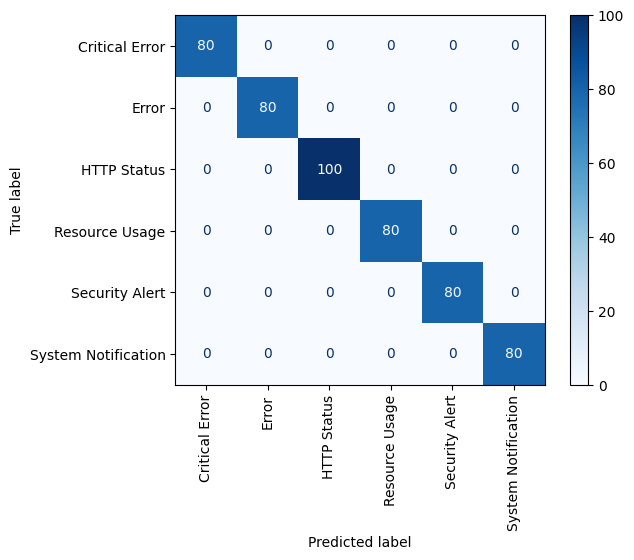

['../models/QuadraticDiscriminantAnalysis.joblib']

In [98]:
clf = QuadraticDiscriminantAnalysis(reg_param=0.5)
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.show()

joblib.dump(clf, '../models/QuadraticDiscriminantAnalysis.joblib')

In [33]:
classifiers = [
    ("Logistic Regression", LogisticRegression(max_iter=1000), True),
    ("K-Nearest Neighbors", KNeighborsClassifier(n_neighbors=5), True),
    ("Support Vector Machine", SVC(kernel='rbf', C=1, gamma='scale'), True),
    ("Decision Tree", DecisionTreeClassifier(max_depth=5, random_state=42), False),
    ("Random Forest", RandomForestClassifier(n_estimators=100, random_state=42), False),
    ("AdaBoost", AdaBoostClassifier(n_estimators=100, random_state=42), False),
    ("Naive Bayes", GaussianNB(), False),
    ("Neural Network", MLPClassifier(hidden_layer_sizes=(100,), max_iter=700, random_state=42), True),
    ("Linear Discriminant Analysis", LinearDiscriminantAnalysis(), True),
    ("Quadratic Discriminant Analysis", QuadraticDiscriminantAnalysis(), True)
]

# Evaluate each classifier
results = []
for name, clf, needs_scaling in classifiers:
    if needs_scaling:
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', clf)
        ])
    else:
        pipeline = Pipeline([
            ('classifier', clf)
        ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted', zero_division=0),
        'Recall': recall_score(y_test, y_pred, average='weighted', zero_division=0),
        'F1 Score': f1_score(y_test, y_pred, average='weighted', zero_division=0)
    })

# Display results
results_df = pd.DataFrame(results)
print(results_df.sort_values(by='F1 Score', ascending=False))

c:\Users\romin\Desktop\Projects\project-nlp-log-classification-main\nlp_c\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\romin\Desktop\Projects\project-nlp-log-classification-main\nlp_c\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\romin\Desktop\Projects\project-nlp-log-classification-main\nlp_c\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 2 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\romin\Desktop\Projects\project-nlp-log-classification-main\nlp_c\Lib\site-packages\sklearn\discri

                             Model  Accuracy  Precision    Recall  F1 Score
0              Logistic Regression  1.000000   1.000000  1.000000  1.000000
1              K-Nearest Neighbors  1.000000   1.000000  1.000000  1.000000
2           Support Vector Machine  1.000000   1.000000  1.000000  1.000000
4                    Random Forest  1.000000   1.000000  1.000000  1.000000
8     Linear Discriminant Analysis  1.000000   1.000000  1.000000  1.000000
7                   Neural Network  1.000000   1.000000  1.000000  1.000000
6                      Naive Bayes  0.966814   0.976401  0.966814  0.969393
5                         AdaBoost  0.962389   0.964176  0.962389  0.963071
3                    Decision Tree  0.929204   0.935892  0.929204  0.931124
9  Quadratic Discriminant Analysis  0.464602   0.215855  0.464602  0.294762


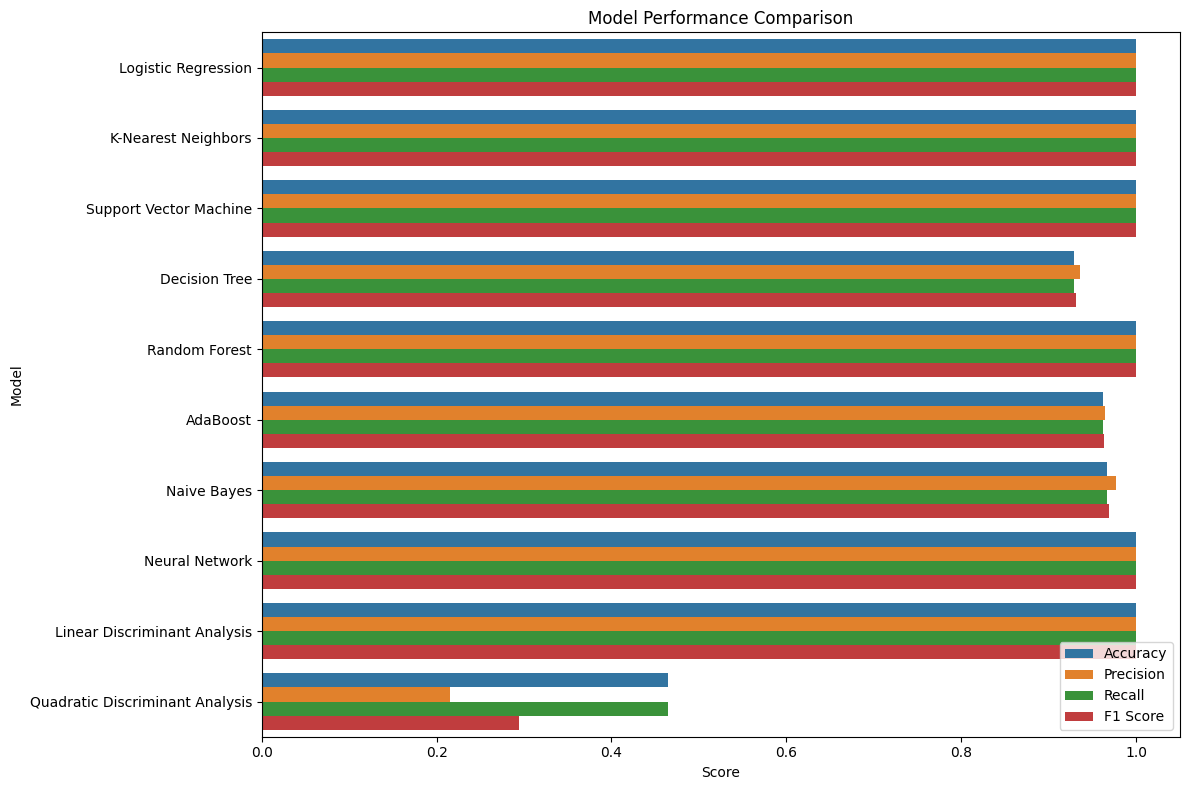

In [32]:
# Set the figure size
plt.figure(figsize=(12, 8))

# Melt the DataFrame for easier plotting
results_melted = results_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Create a barplot
sns.barplot(data=results_melted, x='Score', y='Model', hue='Metric')

# Add title and labels
plt.title('Model Performance Comparison')
plt.xlabel('Score')
plt.ylabel('Model')

# Display the legend
plt.legend(loc='lower right')

# Show the plot
plt.tight_layout()
plt.show()

| Model                                     | Accuracy | Training Time | Prediction Time | Memory Usage | Notes                                                               |                                                               |
| ----------------------------------------- | -------- | ------------- | --------------- | ------------ | ------------------------------------------------------------------- | ------------------------------------------------------------- |
| **Logistic Regression**                   | 1.000    | Low           | Very Low        | Low          | Fast, interpretable, ideal for linearly separable data              |                                                               |
| **K-Nearest Neighbors (KNN)**             | 1.000    | None          | High            | High         | No training phase; slow predictions due to distance calculations    |                                                               |
| **Support Vector Machine (SVM)**          | 1.000    | Moderate      | Moderate        | Moderate     | Effective in high-dimensional spaces; kernel choice impacts speed   |                                                               |
| **Neural Network**                        | 1.000    | High          | Moderate        | High         | Requires substantial resources; potential overfitting on small data |                                                               |
| **Linear Discriminant Analysis (LDA)**    | 0.998    | Low           | Very Low        | Low          | Assumes normal distribution; efficient and interpretable            |                                                               |
| **Random Forest**                         | 0.996    | High          | Moderate        | High         | Robust to overfitting; ensemble method increases resource usage     |                                                               |
| **AdaBoost**                              | 0.980    | High          | Moderate        | Moderate     | Sensitive to noisy data; combines weak learners                     |                                                               |
| **Naive Bayes**                           | 0.931    | Very Low      | Very Low        | Very Low     | Assumes feature independence; fast but less accurate                |                                                               |
| **Decision Tree**                         | 0.927    | Low           | Very Low        | Low          | Prone to overfitting; simple to interpret                           |                                                               |
| **Quadratic Discriminant Analysis (QDA)** | 0.465    | Low           | Very Low        | Low          | Assumes different covariance; poor 



In [ ]:
model_embedding = SentenceTransformer('all-MiniLM-L6-v2')  # Lightweight embedding model
model_classification = joblib.load("models/log_classifier.joblib")


def classify_with_bert(log_message):
    embeddings = model_embedding.encode([log_message])
    probabilities = model_classification.predict_proba(embeddings)[0]
    if max(probabilities) < 0.5:
        return "Unclassified"
    predicted_label = model_classification.predict(embeddings)[0]
    
    return predicted_label